Number of true labels: 688
2035 4 659 1
- preds shape: (688, 2)
- feats shape: (688, 512)
[[0.21310452 0.00583279 0.21640353 ... 0.24545717 0.34226838 0.6057361 ]
 [0.10471056 0.         0.31850344 ... 0.         0.05014025 0.34539786]
 [0.17165117 0.         0.5455779  ... 0.1120905  0.09273683 0.15411755]
 ...
 [0.         0.00455331 0.48450336 ... 0.06457445 0.4684836  0.14933833]
 [0.16837667 0.         0.27419755 ... 0.2623207  0.27731785 0.07953698]
 [0.06680522 0.         0.40453637 ... 0.07642032 0.18158157 0.01044957]]
(688, 2)
[[ 3.879648    0.08411123]
 [-1.0492523  -1.921451  ]
 [-0.42226535  1.0383    ]
 ...
 [-0.53262115 -1.1677815 ]
 [-1.3757704  -1.451605  ]
 [-1.9982337  -0.9799865 ]]


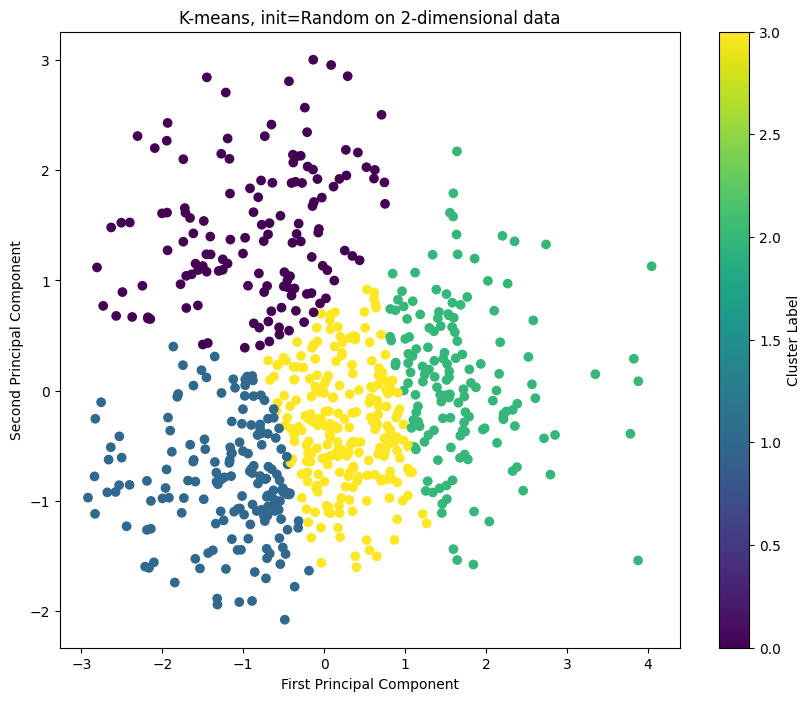

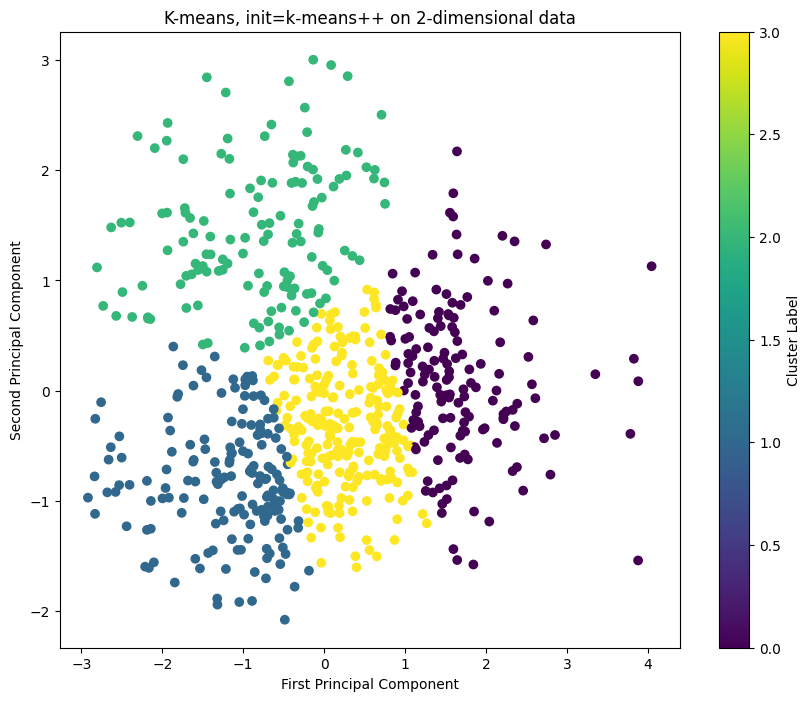

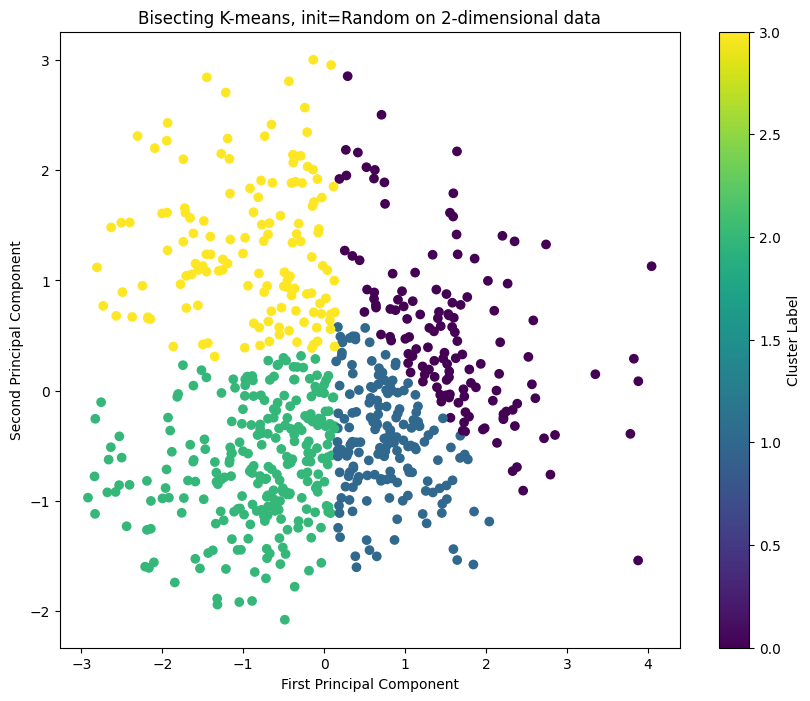

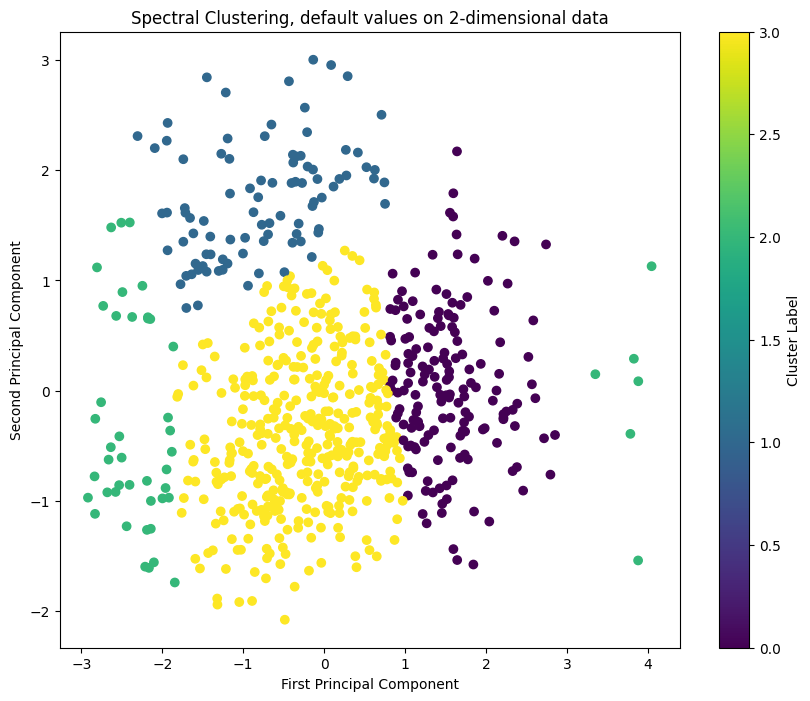

Estimated number of clusters: 4
It works with a few values, but we want the clusters to be more sparse, so min_samples low (4) and eps = 0.255 gives us 4 clusters



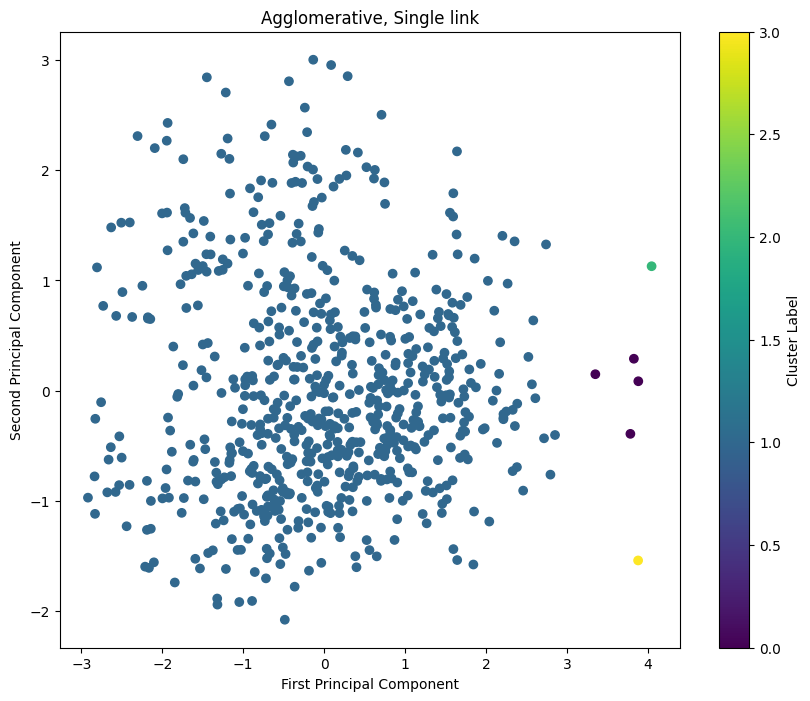

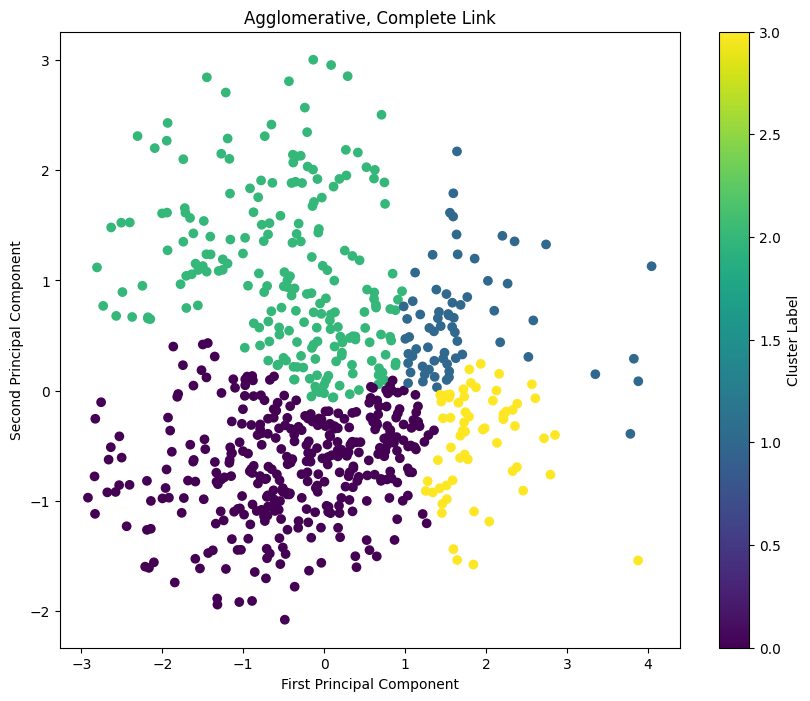

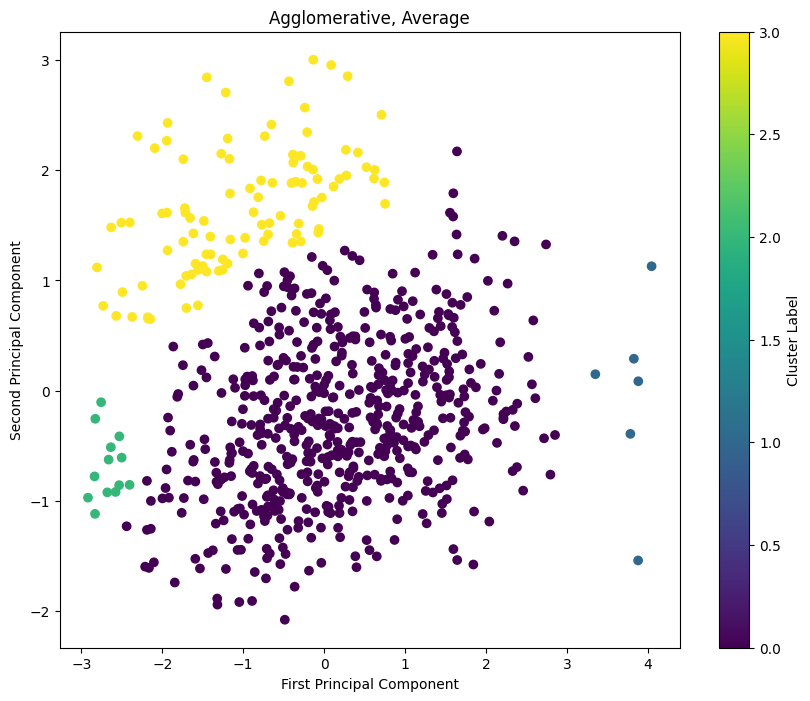

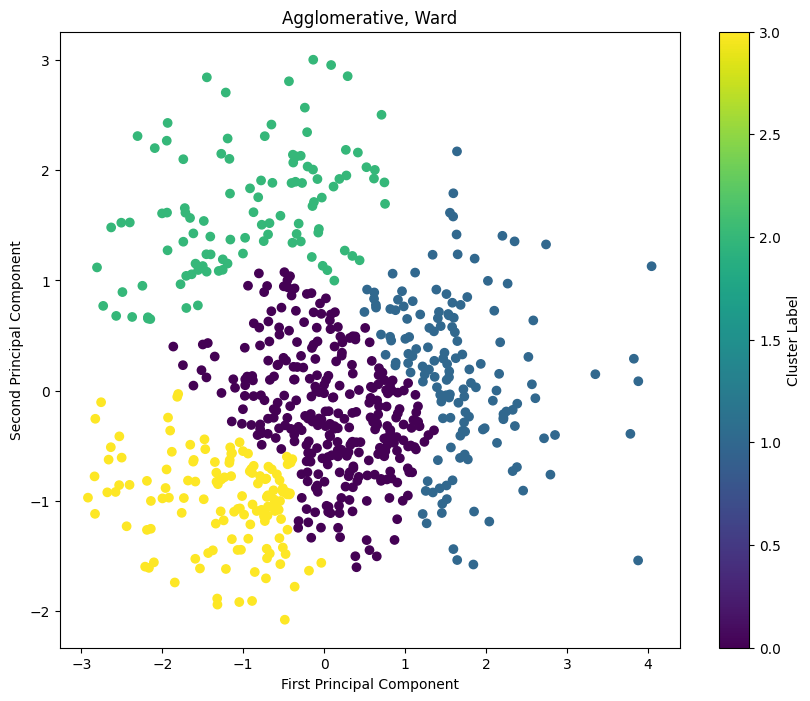


(c): Fowlkes-Mallows Index sorted from high to low:
Single Linkage: 0.4966
Group Average: 0.4232
Spectral Clustering: 0.3154
Complete Linkage: 0.3029
Wards Method: 0.2850
Bisecting Kmeans: 0.2596
Kmeans (init=random): 0.2588
Kmeans (init=kmeans++): 0.2588

(d): Silhouette Scores sorted from high to low:
Single Linkage: 0.4476
Kmeans (init=random): 0.3461
Kmeans (init=kmeans++): 0.3461
Spectral Clustering: 0.3382
Wards Method: 0.3146
Bisecting Kmeans: 0.3131
Group Average: 0.2628
Complete Linkage: 0.2624


In [105]:
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
from PIL import Image
from pathlib import Path
import glob

import skimage.exposure
from skimage import data
from skimage.color import rgb2gray
from skimage import filters
from skimage import io
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, BisectingKMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.metrics import fowlkes_mallows_score, silhouette_score

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
#!pip install timm
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os


#1. (Feature Extraction):

def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox


def get_image(annot):
    base_path = './stanford-dogs-dataset/images'
    img_path = os.path.join(base_path, 'Images')

    # Normalize the annotation path and split it
    annot_parts = os.path.normpath(annot).split(os.sep)

    # Extract the breed folder and image name
    breed_folder = annot_parts[-2]
    image_name = os.path.splitext(annot_parts[-1])[0]  # Remove the extension

    # Construct the image filename
    img_filename = os.path.join(img_path, breed_folder, f"{image_name}.jpg")

    return img_filename


if __name__ == '__main__':
    dog_images = glob.glob('./stanford-dogs-dataset/images/Images/*/*')
    breeds = glob.glob('./stanford-dogs-dataset/annotations/Annotation/*')
    annotations = glob.glob('./stanford-dogs-dataset/annotations/Annotation/*/*')

    normalized_images = []
    true_labels = []
    
    for i in range(len(annotations)):
        bbox = get_bounding_boxes(annotations[i])
        dog = get_image(annotations[i])
        im = Image.open(dog)
        breed = os.path.basename(os.path.dirname(annotations[i]))
        for j in range(len(bbox)):
            true_labels.append(breed)
            im2 = im.crop(bbox[j])
            im2 = im2.resize((224, 224), Image.Resampling.LANCZOS)
            im2_array = np.array(im2)
            # Normalize the image (pixel value scaling method)
            im2_normalized = (im2_array / 255.0).astype(np.float32)
            normalized_images.append(im2_normalized)
            # Convert back to PIL Image
            im2_normalized = Image.fromarray((im2_normalized * 255).astype(np.uint8))
            
            new_path = dog.replace('./stanford-dogs-dataset/images/Images/', './Cropped/')
            new_path = new_path.replace('.jpg', '-' + str(j) + '-1.jpg')
            im2 = im2.convert('RGB')
            head, tail = os.path.split(new_path)
            Path(head).mkdir(parents=True, exist_ok=True)
            im2.save(new_path)

    print(f"Number of true labels: {len(true_labels)}")
    print(len(dog_images), len(breeds), len(annotations), len(bbox))
    
    #Assuming your images are in the './Cropped' directory
    image_dir = '../stanford-dogs-dataset/images/Images'

    #Create a list to store image information
    #image_data = []

    device = torch.device("cuda")
    # Load pre-trained ResNet18 model
    model = timm.create_model('resnet18', pretrained=True)
    model.fc = nn.Linear(512,2)
    model = model.to(device)
    transforms = A.Compose([A.Resize(height=224, width=224), A.Normalize(), ToTensorV2()])
    
    # Create a DataFrame
    image_info = []
    for i, img in enumerate(normalized_images):
        image_info.append({
            'image_id': f'image_{i}.jpg',  # You might want to use actual filenames if available
            'image_array': img
        })
    df = pd.DataFrame(image_info)

    # Create dataset and dataloader
    dataset = ImageData(df, root_dir=image_dir, transform=transforms)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

    # Function to get features from the last convolutional layer
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook

    PREDS = []
    FEATS = []
    # Register the hook
    features = {}
    model.global_pool.register_forward_hook(get_features('feats'))

    for idx, inputs in enumerate(dataloader):
        # move to device
        inputs = inputs.to(device)

        # forward pass [with feature extraction]
        preds = model(inputs)

        # add feats and preds to lists
        PREDS.append(preds.detach().cpu().numpy())
        FEATS.append(features["feats"].cpu().numpy())
        if idx == 21:
            break

    if PREDS:
        PREDS = np.concatenate(PREDS)
        FEATS = np.concatenate(FEATS)
        print("- preds shape:", PREDS.shape)
        print("- feats shape:", FEATS.shape)
        print(FEATS)
    else:
        print("No predictions were made.")

#2. (Dimension Reduction): 
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(FEATS)
    print(pca_features.shape)
    print(pca_features)

#3. (Clustering Algorithm):
    # Kmeans, K = 4:
    # (a) K-means clustering (with init = 'random')
    kmeansa = KMeans(n_clusters=4, init='random', n_init=10, random_state=42)
    cluster_labels = kmeansa.fit_predict(pca_features)
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('K-means, init=Random on 2-dimensional data')
    plt.colorbar(label='Cluster Label')
    plt.show()

    # (b) K-means (with init = 'k-means++'):
    kmeansb = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
    cluster_labels = kmeansb.fit_predict(pca_features)
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('K-means, init=k-means++ on 2-dimensional data')
    plt.colorbar(label='Cluster Label')
    plt.show()

    # (c) Bisecting K-means (with init = 'random')
    kmeansc = BisectingKMeans(n_clusters=4, init='random', n_init=10, random_state=42)
    cluster_labels = kmeansc.fit_predict(pca_features)
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Bisecting K-means, init=Random on 2-dimensional data')
    plt.colorbar(label='Cluster Label')
    plt.show()

    # (d) Spectral Clustering (default)
    kmeansd = SpectralClustering(n_clusters=4)
    cluster_labels = kmeansd.fit_predict(pca_features)
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Spectral Clustering, default values on 2-dimensional data')
    plt.colorbar(label='Cluster Label')
    plt.show()

    # DBSCAN:
    db = DBSCAN(eps=0.255, min_samples=4).fit(pca_features)
    labels = db.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("It works with a few values, but we want the clusters to be more sparse, so min_samples low (4) and eps = 0.255 gives us 4 clusters\n")

    # Hierarchical Clustering:
    # (a) Single link (MIN):
    clusteringa = AgglomerativeClustering(n_clusters=4, linkage='single').fit(pca_features)
    cluster_labels = clusteringa.fit_predict(pca_features)
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Agglomerative, Single link')
    plt.colorbar(label='Cluster Label')
    plt.show()

    # (b) Complete link (MAX):
    clusteringb = AgglomerativeClustering(n_clusters=4, linkage='complete').fit(pca_features)
    cluster_labels = clusteringb.fit_predict(pca_features)
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Agglomerative, Complete Link')
    plt.colorbar(label='Cluster Label')
    plt.show()

    # (c) Group Average:
    clusteringc = AgglomerativeClustering(n_clusters=4, linkage='average').fit(pca_features)
    cluster_labels = clusteringc.fit_predict(pca_features)
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Agglomerative, Average')
    plt.colorbar(label='Cluster Label')
    plt.show()

    # (d) Ward:
    clusteringd = AgglomerativeClustering(n_clusters=4, linkage='ward').fit(pca_features)
    cluster_labels = clusteringd.fit_predict(pca_features)
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Agglomerative, Ward')
    plt.colorbar(label='Cluster Label')
    plt.show()

    # 4. Clustering Evaluations:
    # (a) Fowlkes Mallows index, and (b) Silhouette Scores:
    cluster_labels = kmeansa.fit_predict(pca_features)
    fm_index_kmeansa = fowlkes_mallows_score(true_labels, cluster_labels)
    silhouette_kmeansa = silhouette_score(pca_features, cluster_labels)
    #print("Kmeans, init=random: ", fm_index_kmeansa)
    #print("Kmeans, init=random, silhouette: ", silhouette_kmeansa)

    cluster_labels = kmeansb.fit_predict(pca_features)
    fm_index_kmeansb = fowlkes_mallows_score(true_labels, cluster_labels)
    silhouette_kmeansb = silhouette_score(pca_features, cluster_labels)

    cluster_labels = kmeansc.fit_predict(pca_features)
    fm_index_kmeansc = fowlkes_mallows_score(true_labels, cluster_labels)
    silhouette_kmeansc = silhouette_score(pca_features, cluster_labels)

    cluster_labels = kmeansd.fit_predict(pca_features)
    fm_index_kmeansd = fowlkes_mallows_score(true_labels, cluster_labels)
    silhouette_kmeansd = silhouette_score(pca_features, cluster_labels)

    cluster_labels = clusteringa.fit_predict(pca_features)
    clusteringa = fowlkes_mallows_score(true_labels, cluster_labels)
    silhouette_clusteringa = silhouette_score(pca_features, cluster_labels)

    cluster_labels = clusteringb.fit_predict(pca_features)
    clusteringb = fowlkes_mallows_score(true_labels, cluster_labels)
    silhouette_clusteringb = silhouette_score(pca_features, cluster_labels)

    cluster_labels = clusteringc.fit_predict(pca_features)
    clusteringc = fowlkes_mallows_score(true_labels, cluster_labels)
    silhouette_clusteringc = silhouette_score(pca_features, cluster_labels)

    cluster_labels = clusteringd.fit_predict(pca_features)
    clusteringd = fowlkes_mallows_score(true_labels, cluster_labels)
    silhouette_clusteringd = silhouette_score(pca_features, cluster_labels)

    # (c) Fowlkes Mallows rankings:
    fm_indices = {
        'Kmeans (init=random)': fm_index_kmeansa,
        'Kmeans (init=kmeans++)': fm_index_kmeansb,
        'Bisecting Kmeans': fm_index_kmeansc,
        'Spectral Clustering': fm_index_kmeansd,
        'Single Linkage': clusteringa,
        'Complete Linkage': clusteringb,
        'Group Average': clusteringc,
        'Wards Method': clusteringd
    }
    sorted_fm_indices = sorted(fm_indices.items(), key=lambda item: item[1], reverse=True)
    print("\n(c): Fowlkes-Mallows Index sorted from high to low:")
    for method, score in sorted_fm_indices:
        print(f"{method}: {score:.4f}")

    # (d) Silhouette Score rankings:
    silhouette_scores = {
        'Kmeans (init=random)': silhouette_kmeansa,
        'Kmeans (init=kmeans++)': silhouette_kmeansb,
        'Bisecting Kmeans': silhouette_kmeansc,
        'Spectral Clustering': silhouette_kmeansd,
        'Single Linkage': silhouette_clusteringa,
        'Complete Linkage': silhouette_clusteringb,
        'Group Average': silhouette_clusteringc,
        'Wards Method': silhouette_clusteringd
    }
    sorted_silhouette_scores = sorted(silhouette_scores.items(), key=lambda item: item[1], reverse=True)
    print("\n(d): Silhouette Scores sorted from high to low:")
    for method, score in sorted_silhouette_scores:
        print(f"{method}: {score:.4f}")

In [4]:
class ImageData(Dataset):
    def __init__(self, data, root_dir, transform):
        self.data = data
        self.directory = root_dir
        self.transform = transform

    # length
    def __len__(self):
        return len(self.data)

    # get item
    def __getitem__(self, idx):
        # import
        image = self.data.iloc[idx]['image_array']
        image = (image * 255).astype(np.uint8)
    
        # augmentations
        image = self.transform(image=image)["image"]    
        return image

In [8]:
torch.cuda.is_available()
print(df)

                   image_id                    breed
0    n02093991_1026-0-1.jpg  n02093991-Irish_terrier
1    n02093991_1038-0-1.jpg  n02093991-Irish_terrier
2    n02093991_1105-0-1.jpg  n02093991-Irish_terrier
3     n02093991_114-0-1.jpg  n02093991-Irish_terrier
4    n02093991_1142-0-1.jpg  n02093991-Irish_terrier
..                      ...                      ...
711  n02105412_7965-0-1.jpg         n02105412-kelpie
712  n02105412_8018-0-1.jpg         n02105412-kelpie
713  n02105412_8166-0-1.jpg         n02105412-kelpie
714   n02105412_855-0-1.jpg         n02105412-kelpie
715   n02105412_893-0-1.jpg         n02105412-kelpie

[716 rows x 2 columns]


In [9]:
print(df.head())
print(df.columns)
print(df.shape)

                 image_id                    breed
0  n02093991_1026-0-1.jpg  n02093991-Irish_terrier
1  n02093991_1038-0-1.jpg  n02093991-Irish_terrier
2  n02093991_1105-0-1.jpg  n02093991-Irish_terrier
3   n02093991_114-0-1.jpg  n02093991-Irish_terrier
4  n02093991_1142-0-1.jpg  n02093991-Irish_terrier
Index(['image_id', 'breed'], dtype='object')
(716, 2)


In [10]:
sample_row = df.iloc[0]
sample_img_name = sample_row['image_id']
sample_breed = sample_row['breed']
sample_path = os.path.join('./stanford-dogs-dataset/images/Images', sample_breed, sample_img_name)

print("Sample image path:", sample_path)
print("Image exists:", os.path.exists(sample_path))

Sample image path: ./stanford-dogs-dataset/images/Images\n02093991-Irish_terrier\n02093991_1026-0-1.jpg
Image exists: True


In [79]:
# DBSCAN:
db = DBSCAN(eps=0.255, min_samples=4).fit(pca_features)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 71


In [92]:
# 4. Clustering Evaluations:
# (a) Fowlkes Mallows index
cluster_labels = kmeansa.fit_predict(pca_features)
fm_index_kmeansa = fowlkes_mallows_score(true_labels, cluster_labels)
print(fm_index_kmeansa)

0.25883136258398304
